# PART 3

### Importing Libraries

In [25]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt  
import matplotlib.dates as mdates 
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from zipfile import ZipFile
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

### Extracting Sales dataset

In [26]:
zip_file_path = 'archive (10).zip'
extract_folder = 'sales_dataset/'
os.makedirs(extract_folder, exist_ok=True)

with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

extracted_files = os.listdir(extract_folder)
extracted_files

['Features data set.csv', 'sales data-set.csv', 'stores data-set.csv']

In [27]:
features_df = pd.read_csv(f"{extract_folder}Features data set.csv")
sales_df = pd.read_csv(f"{extract_folder}sales data-set.csv")
stores_df = pd.read_csv(f"{extract_folder}stores data-set.csv")

In [28]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [29]:
sales_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [30]:
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [31]:
# Handling missing values in the features dataset
features_df.fillna({'MarkDown1': 0, 'MarkDown2': 0, 'MarkDown3': 0, 'MarkDown4': 0, 'MarkDown5': 0,
                    'CPI': features_df['CPI'].median(), 'Unemployment': features_df['Unemployment'].median()}, inplace=True)

# Merging the sales dataset with the stores dataset
sales_stores_df = pd.merge(sales_df, stores_df, on="Store")
sales_stores_df


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,05/02/2010,24924.50,False,A,151315
1,1,1,12/02/2010,46039.49,True,A,151315
2,1,1,19/02/2010,41595.55,False,A,151315
3,1,1,26/02/2010,19403.54,False,A,151315
4,1,1,05/03/2010,21827.90,False,A,151315
...,...,...,...,...,...,...,...
421565,45,98,28/09/2012,508.37,False,B,118221
421566,45,98,05/10/2012,628.10,False,B,118221
421567,45,98,12/10/2012,1061.02,False,B,118221
421568,45,98,19/10/2012,760.01,False,B,118221


In [32]:
# Merging the result with the features dataset
# First, ensure that Date columns are in the same format across all dataframes
features_df['Date'] = pd.to_datetime(features_df['Date'])
sales_stores_df['Date'] = pd.to_datetime(sales_stores_df['Date'])

# Merging on Store and Date
final_df = pd.merge(sales_stores_df, features_df, on=["Store", "Date", "IsHoliday"])
final_df['Store'] = final_df['Store'].astype('category')
final_df['Dept'] = final_df['Dept'].astype('category')

final_df['Year'] = final_df.Date.dt.year
final_df['Month'] = final_df.Date.dt.month
# Encoding categorical variables (Type)

final_df.sort_values(by=['Year','Month'])
final_df = final_df.set_index('Date').copy()
final_df = final_df.sort_index(ascending=True).copy()


/var/folders/rz/xhrygs395zl_w0ctc7cyzsxc0000gn/T/ipykernel_20822/4228574647.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  features_df['Date'] = pd.to_datetime(features_df['Date'])
/var/folders/rz/xhrygs395zl_w0ctc7cyzsxc0000gn/T/ipykernel_20822/4228574647.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  sales_stores_df['Date'] = pd.to_datetime(sales_stores_df['Date'])


### Features plot with time

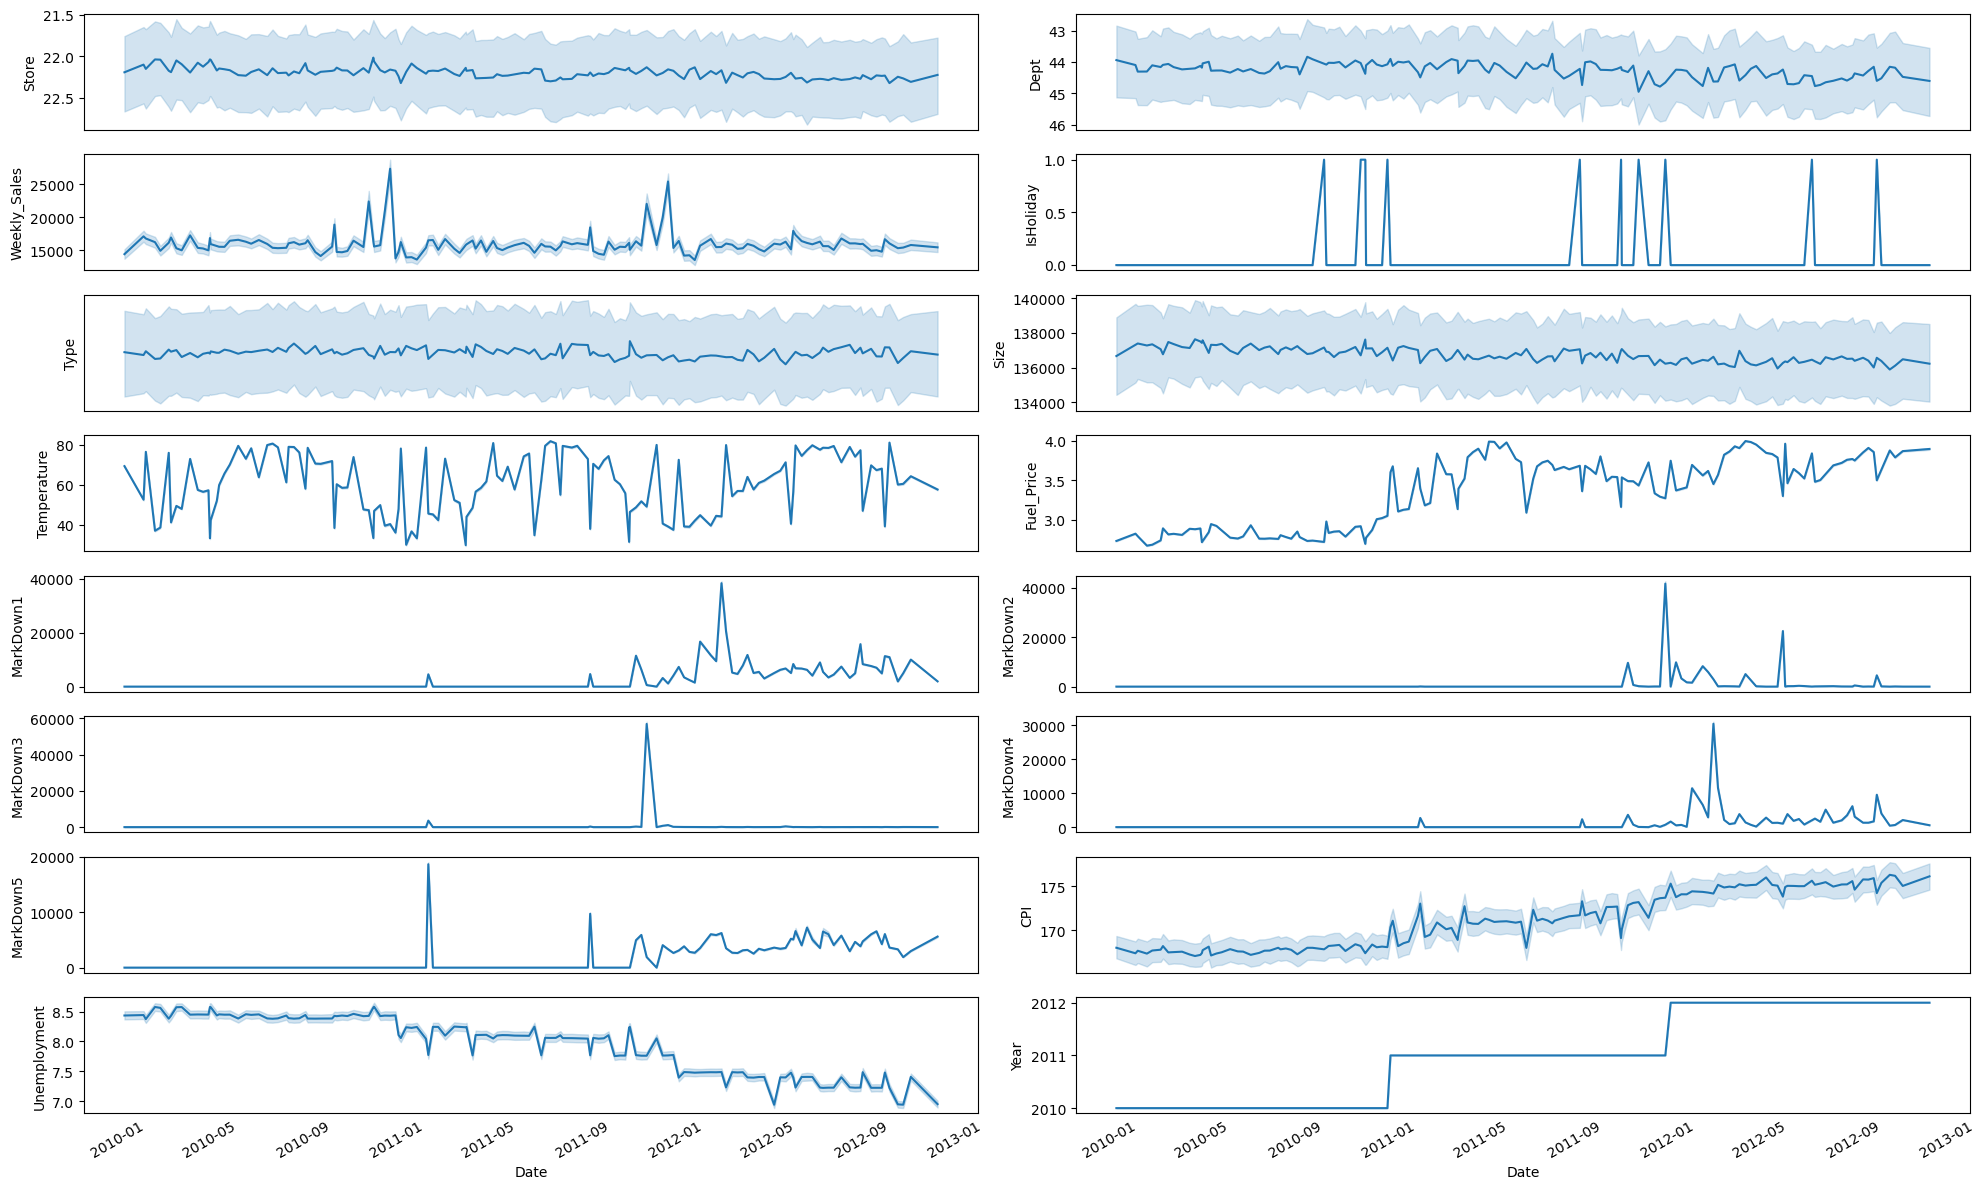

In [9]:
def data_plot(df):
	df_plot = df.copy()

	ncols = 2
	nrows = int(round(df_plot.shape[1] / ncols, 0))

	fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
						sharex=True, figsize=(20, 12))
	for i, ax in enumerate(fig.axes):
		sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
		ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
		ax.xaxis.set_major_locator(mdates.AutoDateLocator())
	fig.tight_layout()
	plt.show()

data_plot(final_df)

In [37]:
final_df

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month
Date,,,,,,,,,,,,,,,,,
2010-01-10,13,14,20922.18,False,A,219622,68.74,2.853,0.00,0.0,0.00,0.00,0.00,126.234600,7.795,2010,1
2010-01-10,40,74,9872.41,False,A,155083,62.01,2.717,0.00,0.0,0.00,0.00,0.00,132.756800,5.287,2010,1
2010-01-10,40,79,10840.77,False,A,155083,62.01,2.717,0.00,0.0,0.00,0.00,0.00,132.756800,5.287,2010,1
2010-01-10,27,98,9837.86,False,A,204184,70.19,2.840,0.00,0.0,0.00,0.00,0.00,136.629757,8.021,2010,1
2010-01-10,27,97,19095.76,False,A,204184,70.19,2.840,0.00,0.0,0.00,0.00,0.00,136.629757,8.021,2010,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-10,6,83,3690.95,False,A,202505,65.43,3.601,1905.34,0.0,13.83,559.50,8706.87,225.005473,5.329,2012,12
2012-12-10,6,85,1645.71,False,A,202505,65.43,3.601,1905.34,0.0,13.83,559.50,8706.87,225.005473,5.329,2012,12
2012-12-10,6,87,44915.71,False,A,202505,65.43,3.601,1905.34,0.0,13.83,559.50,8706.87,225.005473,5.329,2012,12


### Sales Distribution type

Text(0, 0.5, 'Total Sales')

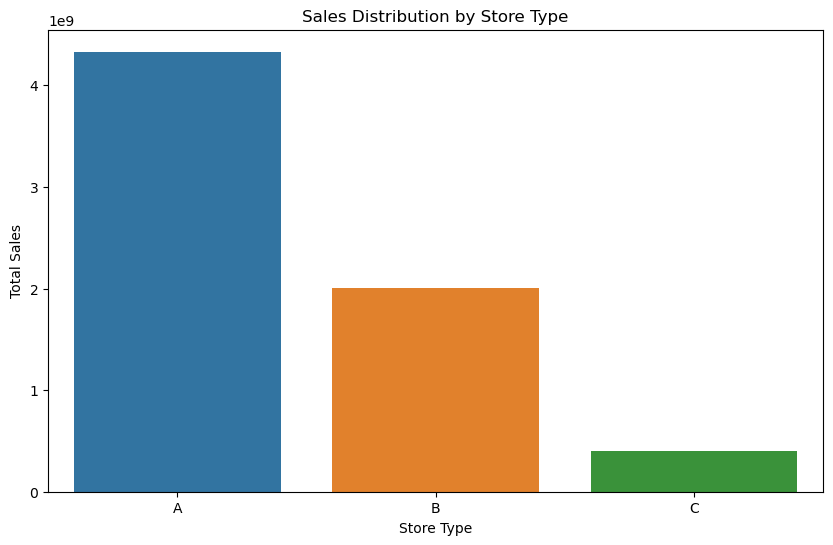

In [35]:
plt.figure(figsize=(10, 6))
store_type_sales = final_df.groupby('Type')['Weekly_Sales'].sum().reset_index()
sns.barplot(x="Type", y="Weekly_Sales", data=store_type_sales)
plt.title("Sales Distribution by Store Type")
plt.xlabel("Store Type")
plt.ylabel("Total Sales")


### Weekly Sales Distribution

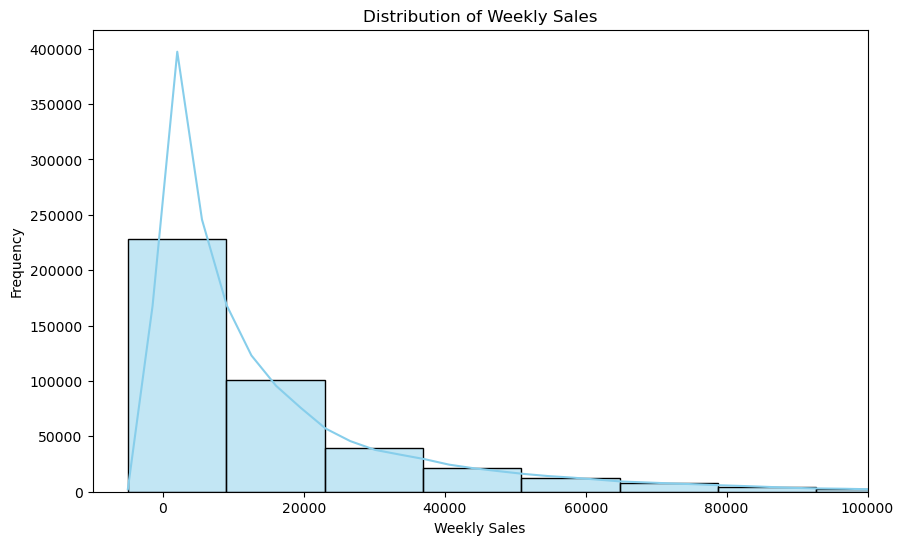

In [45]:
plt.figure(figsize=(10, 6))
sns.histplot(final_df['Weekly_Sales'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.xlim(-10000, 100000)
plt.show()


### Average Weekly Sales during Holidays vs Non-Holidays

/var/folders/rz/xhrygs395zl_w0ctc7cyzsxc0000gn/T/ipykernel_20822/1202206416.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='IsHoliday', y='Weekly_Sales', data=final_df, estimator=np.mean, ci=None, palette='Set1')


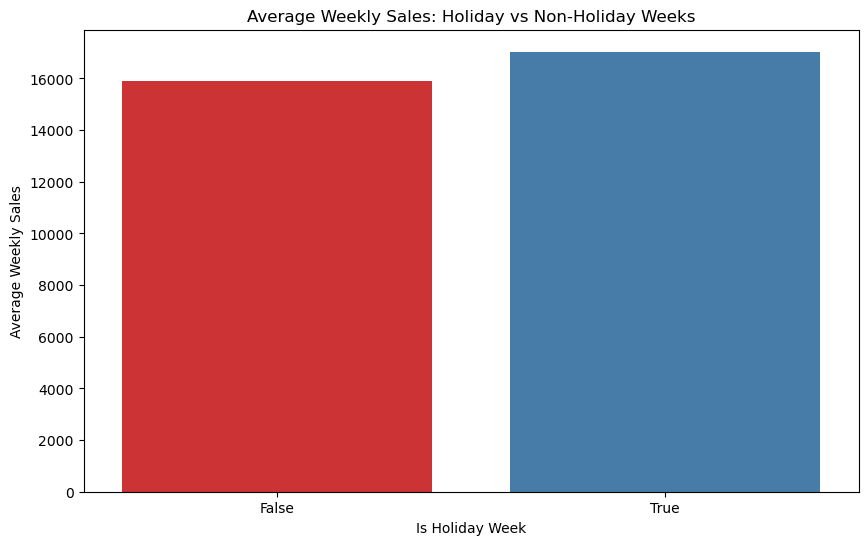

In [41]:
plt.figure(figsize=(10, 6))
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=final_df, estimator=np.mean, ci=None, palette='Set1')
plt.title('Average Weekly Sales: Holiday vs Non-Holiday Weeks')
plt.xlabel('Is Holiday Week')
plt.ylabel('Average Weekly Sales')
plt.show()


Text(0, 0.5, 'Average Weekly Sales')

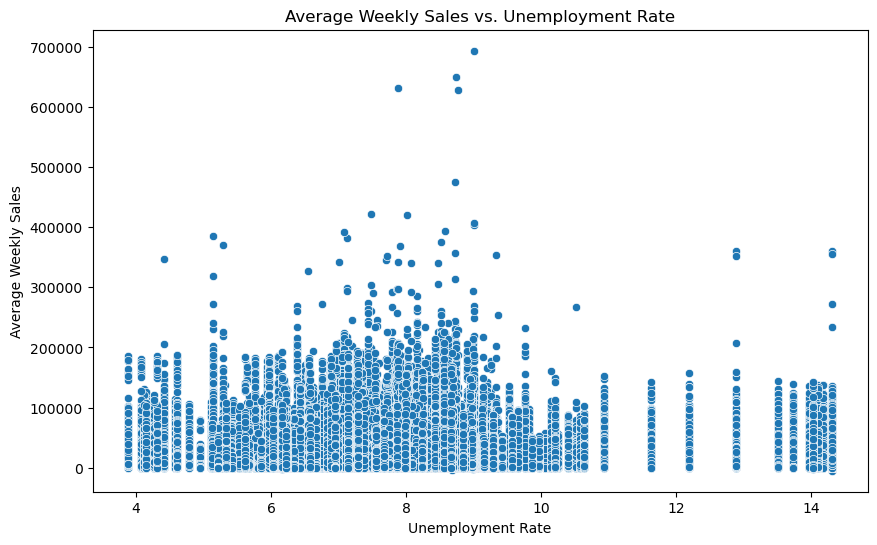

In [42]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Unemployment", y="Weekly_Sales", data=final_df)
plt.title("Average Weekly Sales vs. Unemployment Rate")
plt.xlabel("Unemployment Rate")
plt.ylabel("Average Weekly Sales")

In [10]:
final_df = pd.get_dummies(final_df,columns=['Year','Month','Store','Dept','Type','IsHoliday'])

In [11]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-01-10 to 2012-12-10
Columns: 157 entries, Weekly_Sales to IsHoliday_True
dtypes: float64(10), int64(1), uint8(146)
memory usage: 97.3 MB


In [12]:
final_df.head()

,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,...,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C,IsHoliday_False,IsHoliday_True
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-10,20922.18,219622,68.74,2.853,0.0,0.0,0.0,0.0,0.0,126.234600,...,0,0,0,0,0,1,0,0,1,0
2010-01-10,9872.41,155083,62.01,2.717,0.0,0.0,0.0,0.0,0.0,132.756800,...,0,0,0,0,0,1,0,0,1,0
2010-01-10,10840.77,155083,62.01,2.717,0.0,0.0,0.0,0.0,0.0,132.756800,...,0,0,0,0,0,1,0,0,1,0
2010-01-10,9837.86,204184,70.19,2.840,0.0,0.0,0.0,0.0,0.0,136.629757,...,0,0,0,1,0,1,0,0,1,0
2010-01-10,19095.76,204184,70.19,2.840,0.0,0.0,0.0,0.0,0.0,136.629757,...,0,0,1,0,0,1,0,0,1,0


In [13]:

final_df

,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,...,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C,IsHoliday_False,IsHoliday_True
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-10,20922.18,219622,68.74,2.853,0.00,0.0,0.00,0.00,0.00,126.234600,...,0,0,0,0,0,1,0,0,1,0
2010-01-10,9872.41,155083,62.01,2.717,0.00,0.0,0.00,0.00,0.00,132.756800,...,0,0,0,0,0,1,0,0,1,0
2010-01-10,10840.77,155083,62.01,2.717,0.00,0.0,0.00,0.00,0.00,132.756800,...,0,0,0,0,0,1,0,0,1,0
2010-01-10,9837.86,204184,70.19,2.840,0.00,0.0,0.00,0.00,0.00,136.629757,...,0,0,0,1,0,1,0,0,1,0
2010-01-10,19095.76,204184,70.19,2.840,0.00,0.0,0.00,0.00,0.00,136.629757,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-10,3690.95,202505,65.43,3.601,1905.34,0.0,13.83,559.50,8706.87,225.005473,...,0,0,0,0,0,1,0,0,1,0
2012-12-10,1645.71,202505,65.43,3.601,1905.34,0.0,13.83,559.50,8706.87,225.005473,...,0,0,0,0,0,1,0,0,1,0
2012-12-10,44915.71,202505,65.43,3.601,1905.34,0.0,13.83,559.50,8706.87,225.005473,...,0,0,0,0,0,1,0,0,1,0


In [14]:
scaler = StandardScaler()
numerical_columns = ['Size','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment','Weekly_Sales']
final_df[numerical_columns] = scaler.fit_transform(final_df[numerical_columns])
X_scaled = final_df.drop(columns=['Weekly_Sales']).values
y_scaled = final_df['Weekly_Sales'].values
total_length = len(final_df)
train_length = int(total_length * 0.7)
val_length = int(total_length * 0.85)
X_train, y_train = X_scaled[:train_length], y_scaled[:train_length]
X_val, y_val = X_scaled[train_length:val_length], y_scaled[train_length:val_length]
X_test, y_test = X_scaled[val_length:], y_scaled[val_length:]
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_val = X_val.astype(np.float32)
y_val = y_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [15]:
batch_size = 64
train_loader = DataLoader(TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float()), shuffle=True, batch_size=batch_size)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).float()), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).float()), shuffle=False, batch_size=batch_size)

In [16]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=3):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        if x.dim() == 2:
          x = x.unsqueeze(1)
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
input_size = X_train.shape[1]
hidden_size = 50
output_size = 1
model = RNNModel(input_size, hidden_size, output_size)
model.to(device)




RNNModel(
  (rnn): RNN(156, 50, num_layers=3, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [17]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

def train_test(model, train_loader, val_loader, num_epochs=5):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        print("Epoch: ", epoch+1, "Train Loss: ", train_loss/len(train_loader), "Validation Loss: " ,val_loss/len(val_loader))

train_test(model, train_loader, val_loader, num_epochs=8)


Epoch:  1 Train Loss:  0.22418731360911767 Validation Loss:  0.15635631406205142
Epoch:  2 Train Loss:  0.12496774102599753 Validation Loss:  0.13554326581690532
Epoch:  3 Train Loss:  0.10038254140124672 Validation Loss:  0.14357684201422488
Epoch:  4 Train Loss:  0.08615967137300769 Validation Loss:  0.09189523521036708
Epoch:  5 Train Loss:  0.07225883354957419 Validation Loss:  0.10327693620363308
Epoch:  6 Train Loss:  0.06338058777050079 Validation Loss:  0.2411245632703869
Epoch:  7 Train Loss:  0.056757728836427046 Validation Loss:  0.10170680628166627
Epoch:  8 Train Loss:  0.05331473056884611 Validation Loss:  0.09507193314796737


RMSE:  0.36817518 R^2:  0.8567684517095601


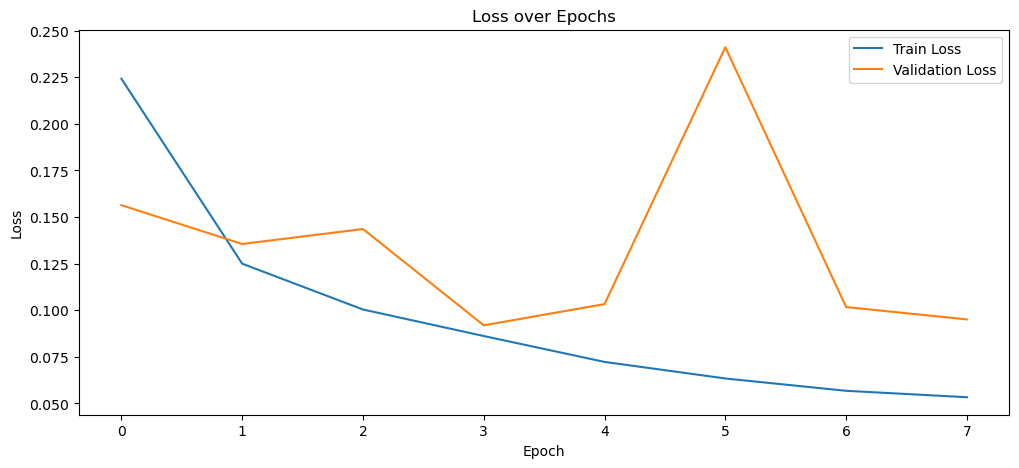

In [18]:
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().cpu().numpy())
        actuals.extend(targets.numpy())

rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
print("RMSE: ",rmse, "R^2: ", r2)

plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
class DropoutRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=3):
        super(DropoutRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        if x.dim() == 2:
          x = x.unsqueeze(1)
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        x = self.dropout(x)
        return x


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
input_size = X_train.shape[1]
hidden_size = 50
output_size = 1
drop_model = DropoutRNN(input_size, hidden_size, output_size)
drop_model.to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(drop_model.parameters(), lr=0.001)

train_losses = []
val_losses = []


train_test(drop_model, train_loader, val_loader, num_epochs=8)


Epoch:  1 Train Loss:  0.6396878208295302 Validation Loss:  0.3334565284097882
Epoch:  2 Train Loss:  0.5846825359060769 Validation Loss:  0.3006294262797936
Epoch:  3 Train Loss:  0.5711787647075468 Validation Loss:  0.32000769942968754
Epoch:  4 Train Loss:  0.5654182791810081 Validation Loss:  0.27184927091379135
Epoch:  5 Train Loss:  0.5696419066977951 Validation Loss:  0.2846165582070577
Epoch:  6 Train Loss:  0.5499550776099259 Validation Loss:  0.278866066895915
Epoch:  7 Train Loss:  0.5540304507109303 Validation Loss:  0.27953176146902375
Epoch:  8 Train Loss:  0.5465677540674175 Validation Loss:  0.2735260599438775


RMSE:  0.5084642 R^2:  0.7268189999610334


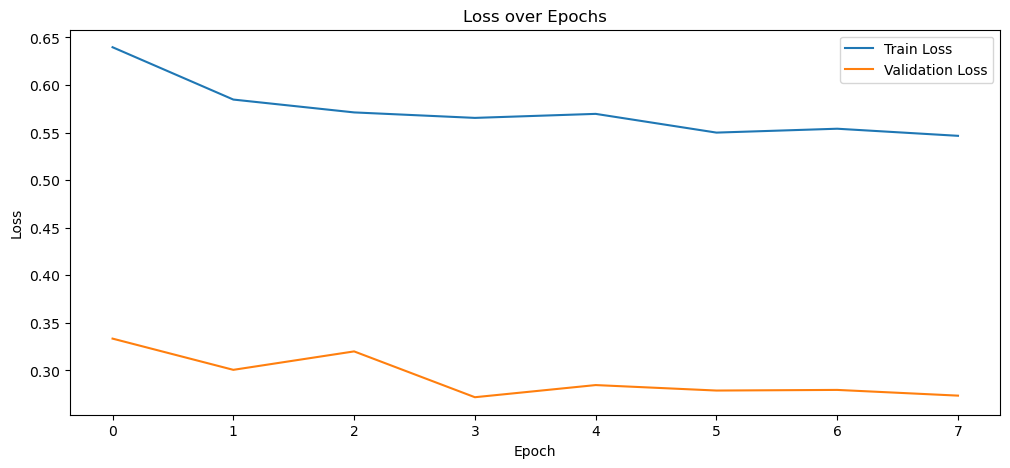

In [20]:
drop_model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = drop_model(inputs)
        predictions.extend(outputs.squeeze().cpu().numpy())
        actuals.extend(targets.numpy())

rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
print("RMSE: ",rmse, "R^2: ", r2)

plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Tuning Learning rate: L2 Regularization

In [21]:
lr_model = RNNModel(input_size, hidden_size, output_size)
lr_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(lr_model.parameters(), lr=0.01)
train_losses = []
val_losses = []


train_test(lr_model, train_loader, val_loader, num_epochs=8)

Epoch:  1 Train Loss:  0.18177467296346358 Validation Loss:  0.13098956448194563
Epoch:  2 Train Loss:  0.12664516528773867 Validation Loss:  0.16518219210644403
Epoch:  3 Train Loss:  0.10853704852255021 Validation Loss:  0.3362551651653976
Epoch:  4 Train Loss:  0.10020993016272414 Validation Loss:  0.1626279333566812
Epoch:  5 Train Loss:  0.09141110504545777 Validation Loss:  0.18070272093071885
Epoch:  6 Train Loss:  0.0882568787664217 Validation Loss:  0.23211679831655702
Epoch:  7 Train Loss:  0.08843003235421258 Validation Loss:  0.752124321208165
Epoch:  8 Train Loss:  0.08930130164086256 Validation Loss:  0.22672880159952763


RMSE:  0.42845222 R^2:  0.806030029231339


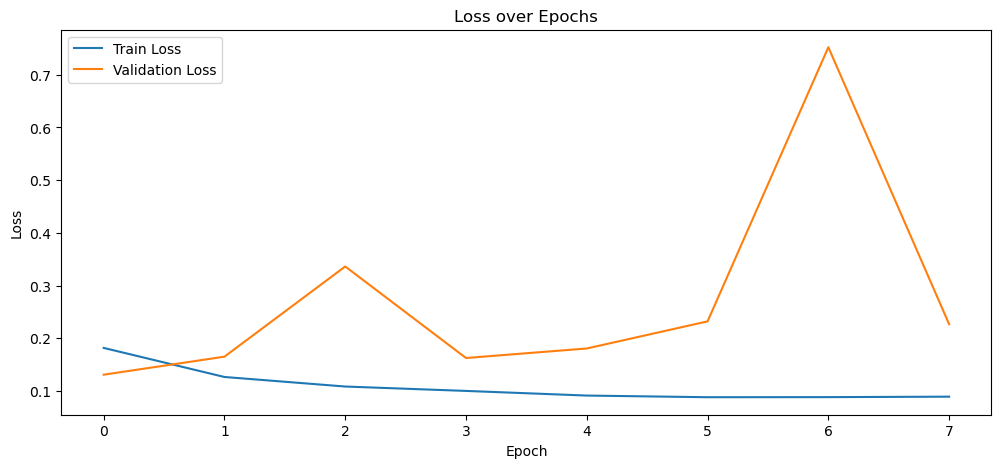

In [22]:
lr_model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = lr_model(inputs)
        predictions.extend(outputs.squeeze().cpu().numpy())
        actuals.extend(targets.numpy())

rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
print("RMSE: ",rmse, "R^2: ", r2)

plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
torch.save(drop_model.state_dict(), 'cnara_neemageo_assignment1_part3.h5')

In [47]:
!pip install torchinfo
from torchinfo import summary

summary(drop_model)

Layer (type:depth-idx)                   Param #
DropoutRNN                               --
├─RNN: 1-1                               20,600
├─Linear: 1-2                            51
├─Dropout: 1-3                           --
Total params: 20,651
Trainable params: 20,651
Non-trainable params: 0

# PART 4

In [ ]:
import pandas
import time
import seaborn
import numpy
import matplotlib.pyplot as graph

import torch
import torch.nn as NeuNet
import torch.optim as Optimizer
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from torch.nn.utils.rnn import pad_sequence


In [ ]:

start_time = time.time()

twitter_dataset = '/content/Tweets.csv'

tweet_dataset = pandas.read_csv(twitter_dataset)
print(tweet_dataset)

end_time = time.time()

elapsed_time = end_time - start_time

print("Time taken to load df is : ", elapsed_time)



                 tweet_id airline_sentiment  airline_sentiment_confidence  \
0      570306133677760513           neutral                        1.0000   
1      570301130888122368          positive                        0.3486   
2      570301083672813571           neutral                        0.6837   
3      570301031407624196          negative                        1.0000   
4      570300817074462722          negative                        1.0000   
...                   ...               ...                           ...   
14635  569587686496825344          positive                        0.3487   
14636  569587371693355008          negative                        1.0000   
14637  569587242672398336           neutral                        1.0000   
14638  569587188687634433          negative                        1.0000   
14639  569587140490866689           neutral                        0.6771   

               negativereason  negativereason_confidence         airline  \

In [ ]:
tweet_dataset.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


In [ ]:
tweet_dataset.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [ ]:
tweet_dataset.count()

tweet_id                        14640
airline_sentiment               14640
airline_sentiment_confidence    14640
negativereason                   9178
negativereason_confidence       10522
airline                         14640
airline_sentiment_gold             40
name                            14640
negativereason_gold                32
retweet_count                   14640
text                            14640
tweet_coord                      1019
tweet_created                   14640
tweet_location                   9907
user_timezone                    9820
dtype: int64

In [ ]:
tweet_dataset.drop(['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord'], axis=1, inplace=True)


In [ ]:
tweet_dataset.count()

tweet_id                        14640
airline_sentiment               14640
airline_sentiment_confidence    14640
negativereason                   9178
negativereason_confidence       10522
airline                         14640
name                            14640
retweet_count                   14640
text                            14640
tweet_created                   14640
tweet_location                   9907
user_timezone                    9820
dtype: int64

In [ ]:
tweet_dataset['negativereason'].fillna('None', inplace=True)

tweet_dataset['tweet_location'].fillna('None', inplace=True)

tweet_dataset['user_timezone'].fillna('0000-00-00 00:00:00', inplace=True)


In [ ]:
tweet_dataset.count()

tweet_id                        14640
airline_sentiment               14640
airline_sentiment_confidence    14640
negativereason                  14640
negativereason_confidence       10522
airline                         14640
name                            14640
retweet_count                   14640
text                            14640
tweet_created                   14640
tweet_location                  14640
user_timezone                   14640
dtype: int64

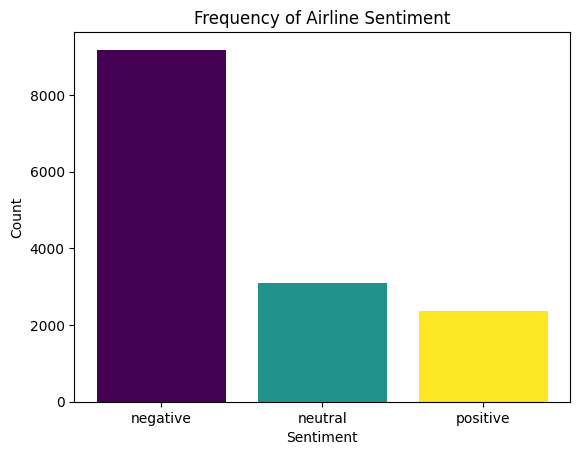

In [ ]:

count_airline_sentiment = tweet_dataset['airline_sentiment'].value_counts()
colors = graph.cm.viridis(numpy.linspace(0, 1, len(count_airline_sentiment)))

graph.bar(count_airline_sentiment.index, count_airline_sentiment, color=colors)
graph.ylabel('Count')
graph.xlabel('Sentiment')
graph.title('Frequency of Airline Sentiment')
graph.show()

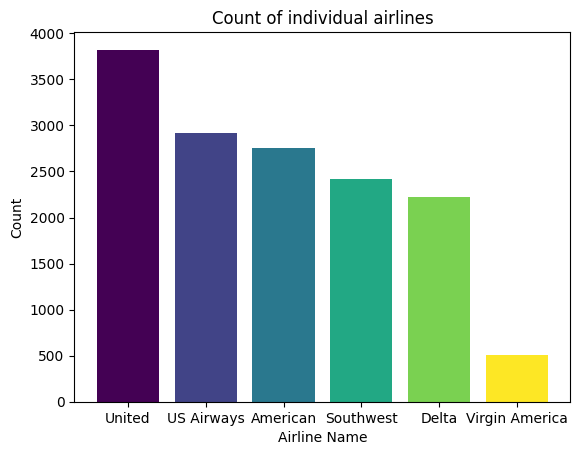

In [ ]:
count_airline = tweet_dataset['airline'].value_counts()
colors = graph.cm.viridis(numpy.linspace(0, 1, len(count_airline)))

graph.bar(count_airline.index, count_airline, color = colors)
graph.ylabel('Count')
graph.xlabel('Airline Name')
graph.title('Count of individual airlines')
graph.show()

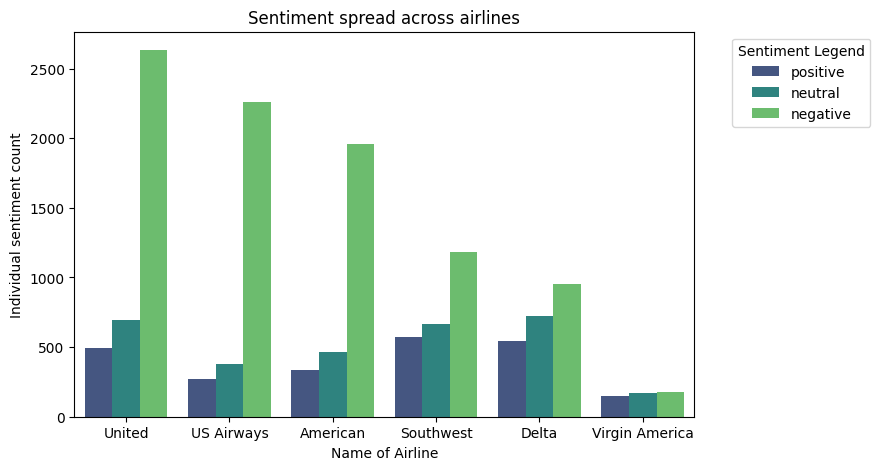

In [ ]:


graph.figure(figsize=(8, 5))

sentiment_order = ['positive', 'neutral', 'negative']

airline_count = tweet_dataset['airline'].value_counts()
seaborn.countplot(data=tweet_dataset, x='airline', hue='airline_sentiment', palette='viridis', order=airline_count.index, hue_order=sentiment_order)

graph.ylabel('Individual sentiment count')
graph.xlabel('Name of Airline')
graph.title('Sentiment spread across airlines')
graph.legend(title='Sentiment Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

graph.show()


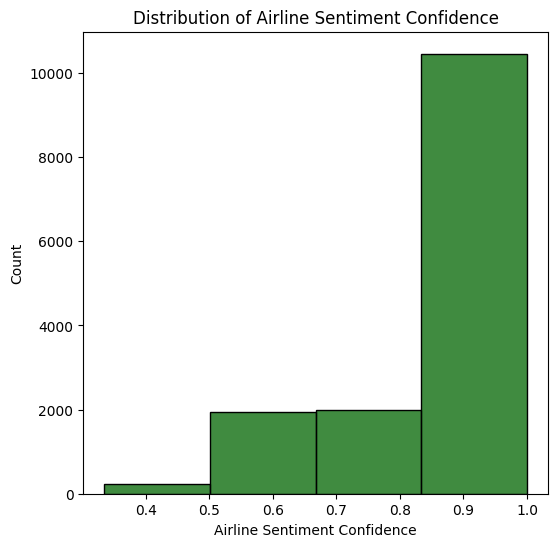

In [ ]:
graph.figure(figsize=(6, 6))
seaborn.histplot(tweet_dataset['airline_sentiment_confidence'], bins=4, kde=False, color='darkgreen')

graph.title('Distribution of Airline Sentiment Confidence')
graph.xlabel('Airline Sentiment Confidence')
graph.ylabel('Count')

graph.show()

In [ ]:


negative_count = tweet_dataset['negativereason'].value_counts()

negative_reasons_spread = pandas.DataFrame({
    'Negative Reason': negative_count.index,
    'Count': negative_count.values
})

print(negative_reasons_spread)

                Negative Reason  Count
0                          None   5462
1        Customer Service Issue   2910
2                   Late Flight   1665
3                    Can't Tell   1190
4              Cancelled Flight    847
5                  Lost Luggage    724
6                    Bad Flight    580
7       Flight Booking Problems    529
8   Flight Attendant Complaints    481
9                     longlines    178
10              Damaged Luggage     74


<ipython-input-15-29df75ab2f1a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  seaborn.barplot(x='Negative Reason', y='Count', data=negative_reasons_spread, palette='viridis')


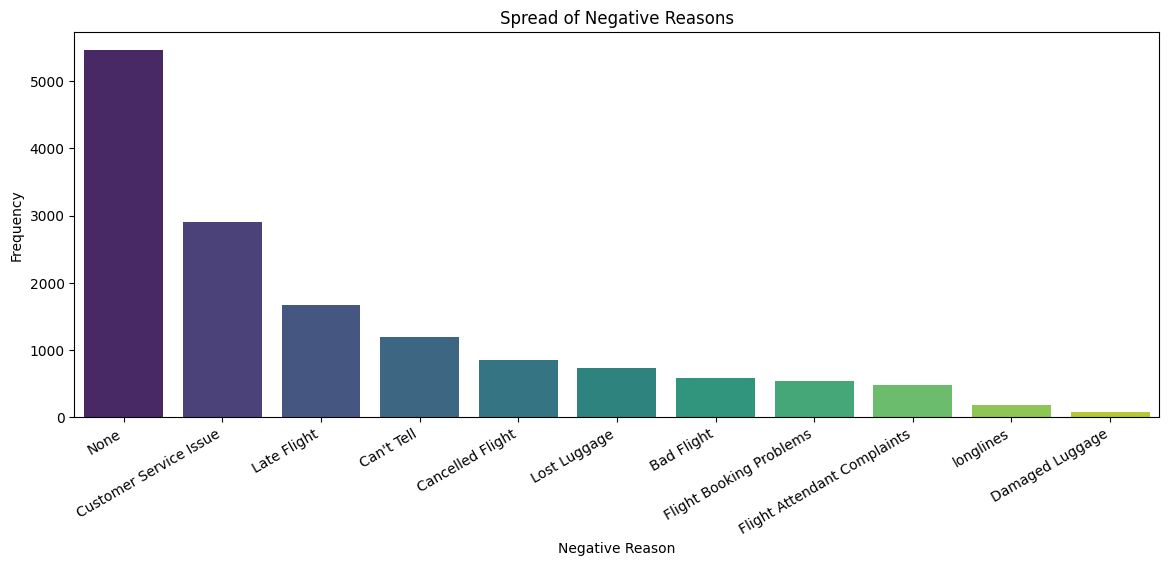

In [ ]:
graph.figure(figsize=(14, 5))
seaborn.barplot(x='Negative Reason', y='Count', data=negative_reasons_spread, palette='viridis')

graph.ylabel('Frequency')
graph.xlabel('Negative Reason')
graph.title('Spread of Negative Reasons')
graph.xticks(rotation=30, ha='right')

graph.show()

In [ ]:

negative_reasons_by_airline = tweet_dataset.groupby(['airline', 'negativereason']).size().reset_index(name='Count')
print(negative_reasons_by_airline)




           airline           negativereason  Count
0         American               Bad Flight     87
1         American               Can't Tell    198
2         American         Cancelled Flight    246
3         American   Customer Service Issue    768
4         American          Damaged Luggage     12
..             ...                      ...    ...
61  Virgin America  Flight Booking Problems     28
62  Virgin America              Late Flight     17
63  Virgin America             Lost Luggage      5
64  Virgin America                     None    323
65  Virgin America                longlines      3

[66 rows x 3 columns]


<Figure size 1400x1000 with 0 Axes>

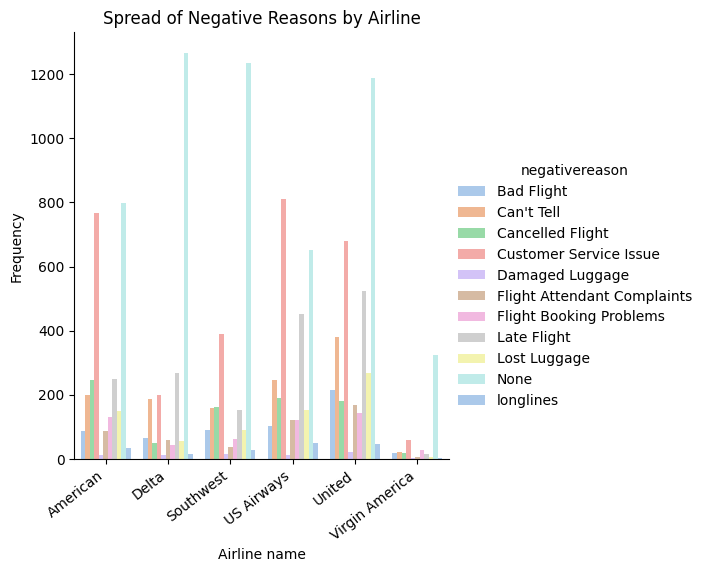

In [ ]:
graph.figure(figsize=(14, 10))
seaborn.catplot(x='airline', y='Count', hue='negativereason', kind='bar', data=negative_reasons_by_airline, palette='pastel')

graph.ylabel('Frequency')
graph.xlabel('Airline name')
graph.title('Spread of Negative Reasons by Airline')
graph.xticks(rotation=38, ha='right')

graph.show()

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:



df = tweet_dataset

stop_words = set(stopwords.words('english'))
df['tokenized_text'] = df['text'].apply(lambda x: word_tokenize(str(x).lower()))
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [word for word in x if word.isalpha() and word not in stop_words])

max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['tokenized_text'])
X_sequences = [torch.tensor(seq) for seq in tokenizer.texts_to_sequences(df['tokenized_text'])]
X_padded = pad_sequence(X_sequences, batch_first=True, padding_value=0)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['airline_sentiment'])

X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

class LSTMModel(NeuNet.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.embedding = NeuNet.Embedding(input_size, embedding_size)
        self.lstm1 = NeuNet.LSTM(embedding_size, hidden_size, batch_first=True)
        self.lstm2 = NeuNet.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = NeuNet.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout = NeuNet.Dropout(0.5)
        self.fc = NeuNet.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        return x

num_classes = 3
model = LSTMModel(max_words, 128, 64, num_classes)

criterion = NeuNet.CrossEntropyLoss()
Optimizerizer = Optimizer.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

best_accuracy = 0.0
best_model_weights = model.state_dict()

epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i, (inputs, labels) in enumerate(train_loader, 1):
        Optimizerizer.zero_grad()
        outputs = model(inputs.long())
        loss = criterion(outputs, labels.long())
        loss.backward()
        Optimizerizer.step()

        if i % 100 == 0:
            print(f"  Batch {i}/{len(train_loader)} - Loss: {loss.item()}")

    with torch.no_grad():
        model.eval()
        val_outputs = model(torch.tensor(X_val).long())
        _, val_predictions = torch.max(val_outputs, 1)
        val_accuracy = accuracy_score(y_val, val_predictions.numpy())
        print(f'Validation Accuracy: {val_accuracy}')

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_weights = model.state_dict()

model.load_state_dict(best_model_weights)

with torch.no_grad():
    model.eval()
    outputs = model(torch.tensor(X_test).long())
    _, predictions = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test, predictions.numpy())

print(f'Test Accuracy: {accuracy}')


<ipython-input-19-75b2c7daaab1>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))


Epoch 1/10
  Batch 100/366 - Loss: 0.7829115986824036
  Batch 200/366 - Loss: 0.8405241370201111
  Batch 300/366 - Loss: 0.8573426604270935


<ipython-input-19-75b2c7daaab1>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(X_val).long())


Validation Accuracy: 0.7383879781420765
Epoch 2/10
  Batch 100/366 - Loss: 0.7801192998886108
  Batch 200/366 - Loss: 0.6022266745567322
  Batch 300/366 - Loss: 0.33408448100090027


<ipython-input-19-75b2c7daaab1>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(X_val).long())


Validation Accuracy: 0.7725409836065574
Epoch 3/10
  Batch 100/366 - Loss: 0.39750608801841736
  Batch 200/366 - Loss: 0.44055891036987305
  Batch 300/366 - Loss: 0.4162346124649048


<ipython-input-19-75b2c7daaab1>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(X_val).long())


Validation Accuracy: 0.7663934426229508
Epoch 4/10
  Batch 100/366 - Loss: 0.35434412956237793
  Batch 200/366 - Loss: 0.598497748374939
  Batch 300/366 - Loss: 0.7279734015464783


<ipython-input-19-75b2c7daaab1>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(X_val).long())


Validation Accuracy: 0.7752732240437158
Epoch 5/10
  Batch 100/366 - Loss: 0.5399675965309143
  Batch 200/366 - Loss: 0.29198676347732544
  Batch 300/366 - Loss: 0.19053082168102264


<ipython-input-19-75b2c7daaab1>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(X_val).long())


Validation Accuracy: 0.7581967213114754
Epoch 6/10
  Batch 100/366 - Loss: 0.24446098506450653
  Batch 200/366 - Loss: 0.2951458692550659
  Batch 300/366 - Loss: 0.07424008846282959


<ipython-input-19-75b2c7daaab1>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(X_val).long())


Validation Accuracy: 0.7602459016393442
Epoch 7/10
  Batch 100/366 - Loss: 0.23057237267494202
  Batch 200/366 - Loss: 0.184658020734787
  Batch 300/366 - Loss: 0.04726990684866905


<ipython-input-19-75b2c7daaab1>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(X_val).long())


Validation Accuracy: 0.7595628415300546
Epoch 8/10
  Batch 100/366 - Loss: 0.26332223415374756
  Batch 200/366 - Loss: 0.2456025779247284
  Batch 300/366 - Loss: 0.04235056787729263


<ipython-input-19-75b2c7daaab1>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(X_val).long())


Validation Accuracy: 0.7534153005464481
Epoch 9/10
  Batch 100/366 - Loss: 0.046536676585674286
  Batch 200/366 - Loss: 0.04752405732870102
  Batch 300/366 - Loss: 0.1185774877667427


<ipython-input-19-75b2c7daaab1>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(X_val).long())


Validation Accuracy: 0.7452185792349727
Epoch 10/10
  Batch 100/366 - Loss: 0.039021048694849014
  Batch 200/366 - Loss: 0.014259765855967999
  Batch 300/366 - Loss: 0.21529996395111084


<ipython-input-19-75b2c7daaab1>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(X_val).long())


Validation Accuracy: 0.7561475409836066


<ipython-input-19-75b2c7daaab1>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(X_test).long())


Test Accuracy: 0.7547814207650273


Changing learning rate (lr = 0.01)

In [ ]:
df = tweet_dataset

stop_words = set(stopwords.words('english'))
df['tokenized_text'] = df['text'].apply(lambda x: word_tokenize(str(x).lower()))
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [word for word in x if word.isalpha() and word not in stop_words])

max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['tokenized_text'])
X_sequences = [torch.tensor(seq) for seq in tokenizer.texts_to_sequences(df['tokenized_text'])]
X_padded = pad_sequence(X_sequences, batch_first=True, padding_value=0)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['airline_sentiment'])

X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

class LSTMModel(NeuNet.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.embedding = NeuNet.Embedding(input_size, embedding_size)
        self.lstm1 = NeuNet.LSTM(embedding_size, hidden_size, batch_first=True)
        self.lstm2 = NeuNet.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = NeuNet.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout = NeuNet.Dropout(0.5)
        self.fc = NeuNet.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        return x

num_classes = 3
model = LSTMModel(max_words, 128, 64, num_classes)

criterion = NeuNet.CrossEntropyLoss()
Optimizerizer = Optimizer.Adam(model.parameters(), lr=0.01)

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

best_accuracy = 0.0
best_model_weights = model.state_dict()

epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i, (inputs, labels) in enumerate(train_loader, 1):
        Optimizerizer.zero_grad()
        outputs = model(inputs.long())
        loss = criterion(outputs, labels.long())
        loss.backward()
        Optimizerizer.step()

        if i % 100 == 0:
            print(f"  Batch {i}/{len(train_loader)} - Loss: {loss.item()}")

    with torch.no_grad():
        model.eval()
        val_outputs = model(torch.tensor(X_val).long())
        _, val_predictions = torch.max(val_outputs, 1)
        val_accuracy = accuracy_score(y_val, val_predictions.numpy())
        print(f'Validation Accuracy: {val_accuracy}')

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_weights = model.state_dict()

model.load_state_dict(best_model_weights)

with torch.no_grad():
    model.eval()
    outputs = model(torch.tensor(X_test).long())
    _, predictions = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test, predictions.numpy())

print(f'Test Accuracy: {accuracy}')


<ipython-input-20-4dc6825f14f5>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))


Epoch 1/10
  Batch 100/366 - Loss: 0.8114640712738037
  Batch 200/366 - Loss: 0.9971328973770142
  Batch 300/366 - Loss: 0.9557279348373413


<ipython-input-20-4dc6825f14f5>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(X_val).long())


Validation Accuracy: 0.6550546448087432
Epoch 2/10
  Batch 100/366 - Loss: 0.5964022278785706
  Batch 200/366 - Loss: 0.9098591208457947
  Batch 300/366 - Loss: 0.585823655128479


<ipython-input-20-4dc6825f14f5>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(X_val).long())


Validation Accuracy: 0.7622950819672131
Epoch 3/10
  Batch 100/366 - Loss: 0.5312437415122986
  Batch 200/366 - Loss: 0.5006857514381409
  Batch 300/366 - Loss: 0.4818459749221802


<ipython-input-20-4dc6825f14f5>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(X_val).long())


Validation Accuracy: 0.7622950819672131
Epoch 4/10
  Batch 100/366 - Loss: 0.3942645788192749
  Batch 200/366 - Loss: 0.6129022240638733
  Batch 300/366 - Loss: 0.6908751130104065


<ipython-input-20-4dc6825f14f5>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(X_val).long())


Validation Accuracy: 0.7711748633879781
Epoch 5/10
  Batch 100/366 - Loss: 0.26186317205429077
  Batch 200/366 - Loss: 0.3666336238384247
  Batch 300/366 - Loss: 0.3358926773071289


<ipython-input-20-4dc6825f14f5>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(X_val).long())


Validation Accuracy: 0.7950819672131147
Epoch 6/10
  Batch 100/366 - Loss: 0.2361806035041809
  Batch 200/366 - Loss: 0.2968914210796356
  Batch 300/366 - Loss: 0.20455928146839142


<ipython-input-20-4dc6825f14f5>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(X_val).long())


Validation Accuracy: 0.7711748633879781
Epoch 7/10
  Batch 100/366 - Loss: 0.10464242845773697
  Batch 200/366 - Loss: 0.2688436508178711
  Batch 300/366 - Loss: 0.28765636682510376


<ipython-input-20-4dc6825f14f5>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(X_val).long())


Validation Accuracy: 0.7759562841530054
Epoch 8/10
  Batch 100/366 - Loss: 0.09576405584812164
  Batch 200/366 - Loss: 0.06213947385549545
  Batch 300/366 - Loss: 0.2654704451560974


<ipython-input-20-4dc6825f14f5>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(X_val).long())


Validation Accuracy: 0.7636612021857924
Epoch 9/10
  Batch 100/366 - Loss: 0.401846319437027
  Batch 200/366 - Loss: 0.23868510127067566
  Batch 300/366 - Loss: 0.18332310020923615


<ipython-input-20-4dc6825f14f5>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(X_val).long())


Validation Accuracy: 0.773224043715847
Epoch 10/10
  Batch 100/366 - Loss: 0.07391379028558731
  Batch 200/366 - Loss: 0.1049736887216568
  Batch 300/366 - Loss: 0.24256715178489685


<ipython-input-20-4dc6825f14f5>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = model(torch.tensor(X_val).long())


Validation Accuracy: 0.7786885245901639


<ipython-input-20-4dc6825f14f5>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(X_test).long())


Test Accuracy: 0.7452185792349727


Changing Dropout Value ( Dropout = 0.2)

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from torch.nn.utils.rnn import pad_sequence


df = tweet_dataset


stop_words = set(stopwords.words('english'))
df['tokenized_text'] = df['text'].apply(lambda x: word_tokenize(str(x).lower()))
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [word for word in x if word.isalpha() and word not in stop_words])


max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['tokenized_text'])
X_sequences = [torch.tensor(seq) for seq in tokenizer.texts_to_sequences(df['tokenized_text'])]
X_padded = pad_sequence(X_sequences, batch_first=True, padding_value=0)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['airline_sentiment'])

X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers=1, bidirectional=True):
        super(ImprovedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        return x

num_classes = 3
improved_model = ImprovedLSTMModel(max_words, 128, 64, num_classes, num_layers=2, bidirectional=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(improved_model.parameters(), lr=0.001)


train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


best_accuracy = 0.0
best_model_weights = improved_model.state_dict()

epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i, (inputs, labels) in enumerate(train_loader, 1):
        optimizer.zero_grad()
        outputs = improved_model(inputs.long())
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"  Batch {i}/{len(train_loader)} - Loss: {loss.item()}")


    with torch.no_grad():
        improved_model.eval()
        val_outputs = improved_model(torch.tensor(X_val).long())
        _, val_predictions = torch.max(val_outputs, 1)
        val_accuracy = accuracy_score(y_val, val_predictions.numpy())
        print(f'Validation Accuracy: {val_accuracy}')


        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_weights = improved_model.state_dict()

improved_model.load_state_dict(best_model_weights)

with torch.no_grad():
    improved_model.eval()
    outputs = improved_model(torch.tensor(X_test).long())
    _, predictions = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test, predictions.numpy())

print(f'Test Accuracy: {accuracy}')


<ipython-input-21-6d2948491eb0>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))


Epoch 1/10
  Batch 100/366 - Loss: 0.8486757874488831
  Batch 200/366 - Loss: 0.8430126309394836
  Batch 300/366 - Loss: 0.7898401618003845


<ipython-input-21-6d2948491eb0>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.6980874316939891
Epoch 2/10
  Batch 100/366 - Loss: 0.7547572255134583
  Batch 200/366 - Loss: 0.6554405093193054
  Batch 300/366 - Loss: 0.5341164469718933


<ipython-input-21-6d2948491eb0>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.6939890710382514
Epoch 3/10
  Batch 100/366 - Loss: 0.4495657980442047
  Batch 200/366 - Loss: 0.5460940599441528
  Batch 300/366 - Loss: 0.5321077108383179


<ipython-input-21-6d2948491eb0>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7657103825136612
Epoch 4/10
  Batch 100/366 - Loss: 0.5207462310791016
  Batch 200/366 - Loss: 0.36994874477386475
  Batch 300/366 - Loss: 0.32856422662734985


<ipython-input-21-6d2948491eb0>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7718579234972678
Epoch 5/10
  Batch 100/366 - Loss: 0.18945905566215515
  Batch 200/366 - Loss: 0.49586525559425354
  Batch 300/366 - Loss: 0.2493370920419693


<ipython-input-21-6d2948491eb0>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7800546448087432
Epoch 6/10
  Batch 100/366 - Loss: 0.4253801703453064
  Batch 200/366 - Loss: 0.4086403250694275
  Batch 300/366 - Loss: 0.46395111083984375


<ipython-input-21-6d2948491eb0>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.773224043715847
Epoch 7/10
  Batch 100/366 - Loss: 0.19154532253742218
  Batch 200/366 - Loss: 0.10149216651916504
  Batch 300/366 - Loss: 0.4975917339324951


<ipython-input-21-6d2948491eb0>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7773224043715847
Epoch 8/10
  Batch 100/366 - Loss: 0.47505322098731995
  Batch 200/366 - Loss: 0.12581470608711243
  Batch 300/366 - Loss: 0.08010205626487732


<ipython-input-21-6d2948491eb0>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7773224043715847
Epoch 9/10
  Batch 100/366 - Loss: 0.03373685106635094
  Batch 200/366 - Loss: 0.1117304340004921
  Batch 300/366 - Loss: 0.14510606229305267


<ipython-input-21-6d2948491eb0>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7663934426229508
Epoch 10/10
  Batch 100/366 - Loss: 0.008243941701948643
  Batch 200/366 - Loss: 0.026583561673760414
  Batch 300/366 - Loss: 0.010857991874217987


<ipython-input-21-6d2948491eb0>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7581967213114754


<ipython-input-21-6d2948491eb0>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = improved_model(torch.tensor(X_test).long())


Test Accuracy: 0.7452185792349727


Improved LSTM

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from torch.nn.utils.rnn import pad_sequence


df = tweet_dataset


stop_words = set(stopwords.words('english'))
df['tokenized_text'] = df['text'].apply(lambda x: word_tokenize(str(x).lower()))
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [word for word in x if word.isalpha() and word not in stop_words])


max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['tokenized_text'])
X_sequences = [torch.tensor(seq) for seq in tokenizer.texts_to_sequences(df['tokenized_text'])]
X_padded = pad_sequence(X_sequences, batch_first=True, padding_value=0)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['airline_sentiment'])

X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers=1, bidirectional=True):
        super(ImprovedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        return x

num_classes = 3
improved_model = ImprovedLSTMModel(max_words, 128, 64, num_classes, num_layers=2, bidirectional=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(improved_model.parameters(), lr=0.001)


train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


best_accuracy = 0.0
best_model_weights = improved_model.state_dict()

epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i, (inputs, labels) in enumerate(train_loader, 1):
        optimizer.zero_grad()
        outputs = improved_model(inputs.long())
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"  Batch {i}/{len(train_loader)} - Loss: {loss.item()}")


    with torch.no_grad():
        improved_model.eval()
        val_outputs = improved_model(torch.tensor(X_val).long())
        _, val_predictions = torch.max(val_outputs, 1)
        val_accuracy = accuracy_score(y_val, val_predictions.numpy())
        print(f'Validation Accuracy: {val_accuracy}')


        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_weights = improved_model.state_dict()

improved_model.load_state_dict(best_model_weights)

with torch.no_grad():
    improved_model.eval()
    outputs = improved_model(torch.tensor(X_test).long())
    _, predictions = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test, predictions.numpy())

print(f'Test Accuracy: {accuracy}')


<ipython-input-22-e159d7ea5071>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))


Epoch 1/10
  Batch 100/366 - Loss: 1.085559368133545
  Batch 200/366 - Loss: 0.9208617210388184
  Batch 300/366 - Loss: 0.8674278855323792


<ipython-input-22-e159d7ea5071>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.6550546448087432
Epoch 2/10
  Batch 100/366 - Loss: 0.7591827511787415
  Batch 200/366 - Loss: 0.9614424109458923
  Batch 300/366 - Loss: 0.7032485604286194


<ipython-input-22-e159d7ea5071>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7336065573770492
Epoch 3/10
  Batch 100/366 - Loss: 0.6773248910903931
  Batch 200/366 - Loss: 0.622247040271759
  Batch 300/366 - Loss: 0.6243508458137512


<ipython-input-22-e159d7ea5071>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.769808743169399
Epoch 4/10
  Batch 100/366 - Loss: 0.4122498631477356
  Batch 200/366 - Loss: 0.39701542258262634
  Batch 300/366 - Loss: 0.24684765934944153


<ipython-input-22-e159d7ea5071>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7882513661202186
Epoch 5/10
  Batch 100/366 - Loss: 0.4611886441707611
  Batch 200/366 - Loss: 0.22528797388076782
  Batch 300/366 - Loss: 0.2914857566356659


<ipython-input-22-e159d7ea5071>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7691256830601093
Epoch 6/10
  Batch 100/366 - Loss: 0.20277372002601624
  Batch 200/366 - Loss: 0.19342826306819916
  Batch 300/366 - Loss: 0.30481278896331787


<ipython-input-22-e159d7ea5071>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7800546448087432
Epoch 7/10
  Batch 100/366 - Loss: 0.05849737673997879
  Batch 200/366 - Loss: 0.23900902271270752
  Batch 300/366 - Loss: 0.1036468893289566


<ipython-input-22-e159d7ea5071>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7711748633879781
Epoch 8/10
  Batch 100/366 - Loss: 0.15207643806934357
  Batch 200/366 - Loss: 0.36078181862831116
  Batch 300/366 - Loss: 0.26418155431747437


<ipython-input-22-e159d7ea5071>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7629781420765027
Epoch 9/10
  Batch 100/366 - Loss: 0.04095769301056862
  Batch 200/366 - Loss: 0.21475182473659515
  Batch 300/366 - Loss: 0.41365116834640503


<ipython-input-22-e159d7ea5071>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7725409836065574
Epoch 10/10
  Batch 100/366 - Loss: 0.08339497447013855
  Batch 200/366 - Loss: 0.04108875244855881
  Batch 300/366 - Loss: 0.03353814780712128


<ipython-input-22-e159d7ea5071>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7841530054644809


<ipython-input-22-e159d7ea5071>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = improved_model(torch.tensor(X_test).long())


Test Accuracy: 0.7370218579234973


Changing Learning Rate (lr = 0.01)

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from torch.nn.utils.rnn import pad_sequence


df = tweet_dataset


stop_words = set(stopwords.words('english'))
df['tokenized_text'] = df['text'].apply(lambda x: word_tokenize(str(x).lower()))
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [word for word in x if word.isalpha() and word not in stop_words])


max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['tokenized_text'])
X_sequences = [torch.tensor(seq) for seq in tokenizer.texts_to_sequences(df['tokenized_text'])]
X_padded = pad_sequence(X_sequences, batch_first=True, padding_value=0)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['airline_sentiment'])

X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers=1, bidirectional=True):
        super(ImprovedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        return x

num_classes = 3
improved_model = ImprovedLSTMModel(max_words, 128, 64, num_classes, num_layers=2, bidirectional=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(improved_model.parameters(), lr=0.01)


train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


best_accuracy = 0.0
best_model_weights = improved_model.state_dict()

epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i, (inputs, labels) in enumerate(train_loader, 1):
        optimizer.zero_grad()
        outputs = improved_model(inputs.long())
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"  Batch {i}/{len(train_loader)} - Loss: {loss.item()}")


    with torch.no_grad():
        improved_model.eval()
        val_outputs = improved_model(torch.tensor(X_val).long())
        _, val_predictions = torch.max(val_outputs, 1)
        val_accuracy = accuracy_score(y_val, val_predictions.numpy())
        print(f'Validation Accuracy: {val_accuracy}')


        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_weights = improved_model.state_dict()

improved_model.load_state_dict(best_model_weights)

with torch.no_grad():
    improved_model.eval()
    outputs = improved_model(torch.tensor(X_test).long())
    _, predictions = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test, predictions.numpy())

print(f'Test Accuracy: {accuracy}')


<ipython-input-23-65ed0256781d>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))


Epoch 1/10
  Batch 100/366 - Loss: 0.9679473638534546
  Batch 200/366 - Loss: 1.0511630773544312
  Batch 300/366 - Loss: 0.7251807451248169


<ipython-input-23-65ed0256781d>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.6550546448087432
Epoch 2/10
  Batch 100/366 - Loss: 0.6889287829399109
  Batch 200/366 - Loss: 0.6709348559379578
  Batch 300/366 - Loss: 0.5167382955551147


<ipython-input-23-65ed0256781d>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7506830601092896
Epoch 3/10
  Batch 100/366 - Loss: 0.5813053250312805
  Batch 200/366 - Loss: 0.41684338450431824
  Batch 300/366 - Loss: 0.45739758014678955


<ipython-input-23-65ed0256781d>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7622950819672131
Epoch 4/10
  Batch 100/366 - Loss: 0.4902710020542145
  Batch 200/366 - Loss: 0.3960154056549072
  Batch 300/366 - Loss: 0.5931589603424072


<ipython-input-23-65ed0256781d>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.769808743169399
Epoch 5/10
  Batch 100/366 - Loss: 0.20170122385025024
  Batch 200/366 - Loss: 0.3604927957057953
  Batch 300/366 - Loss: 0.4482806921005249


<ipython-input-23-65ed0256781d>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7841530054644809
Epoch 6/10
  Batch 100/366 - Loss: 0.15890242159366608
  Batch 200/366 - Loss: 0.3056386411190033
  Batch 300/366 - Loss: 0.2914424240589142


<ipython-input-23-65ed0256781d>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7718579234972678
Epoch 7/10
  Batch 100/366 - Loss: 0.20397831499576569
  Batch 200/366 - Loss: 0.0688769742846489
  Batch 300/366 - Loss: 0.3235895037651062


<ipython-input-23-65ed0256781d>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7657103825136612
Epoch 8/10
  Batch 100/366 - Loss: 0.01495857909321785
  Batch 200/366 - Loss: 0.32249656319618225
  Batch 300/366 - Loss: 0.3930244445800781


<ipython-input-23-65ed0256781d>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7670765027322405
Epoch 9/10
  Batch 100/366 - Loss: 0.1188683807849884
  Batch 200/366 - Loss: 0.25475573539733887
  Batch 300/366 - Loss: 0.2999345362186432


<ipython-input-23-65ed0256781d>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7568306010928961
Epoch 10/10
  Batch 100/366 - Loss: 0.075615793466568
  Batch 200/366 - Loss: 0.39186781644821167
  Batch 300/366 - Loss: 0.10189468413591385


<ipython-input-23-65ed0256781d>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7595628415300546


<ipython-input-23-65ed0256781d>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = improved_model(torch.tensor(X_test).long())


Test Accuracy: 0.7383879781420765


Changing Dropout Value (Droppout = 0.2)

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from torch.nn.utils.rnn import pad_sequence


df = tweet_dataset


stop_words = set(stopwords.words('english'))
df['tokenized_text'] = df['text'].apply(lambda x: word_tokenize(str(x).lower()))
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [word for word in x if word.isalpha() and word not in stop_words])


max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['tokenized_text'])
X_sequences = [torch.tensor(seq) for seq in tokenizer.texts_to_sequences(df['tokenized_text'])]
X_padded = pad_sequence(X_sequences, batch_first=True, padding_value=0)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['airline_sentiment'])

X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers=1, bidirectional=True):
        super(ImprovedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        return x

num_classes = 3
improved_model = ImprovedLSTMModel(max_words, 128, 64, num_classes, num_layers=2, bidirectional=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(improved_model.parameters(), lr=0.001)


train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


best_accuracy = 0.0
best_model_weights = improved_model.state_dict()

epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i, (inputs, labels) in enumerate(train_loader, 1):
        optimizer.zero_grad()
        outputs = improved_model(inputs.long())
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"  Batch {i}/{len(train_loader)} - Loss: {loss.item()}")


    with torch.no_grad():
        improved_model.eval()
        val_outputs = improved_model(torch.tensor(X_val).long())
        _, val_predictions = torch.max(val_outputs, 1)
        val_accuracy = accuracy_score(y_val, val_predictions.numpy())
        print(f'Validation Accuracy: {val_accuracy}')


        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_weights = improved_model.state_dict()

improved_model.load_state_dict(best_model_weights)

with torch.no_grad():
    improved_model.eval()
    outputs = improved_model(torch.tensor(X_test).long())
    _, predictions = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test, predictions.numpy())

print(f'Test Accuracy: {accuracy}')


<ipython-input-24-6d2948491eb0>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))


Epoch 1/10
  Batch 100/366 - Loss: 0.9911603927612305
  Batch 200/366 - Loss: 0.7713797092437744
  Batch 300/366 - Loss: 0.9759814739227295


<ipython-input-24-6d2948491eb0>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.6550546448087432
Epoch 2/10
  Batch 100/366 - Loss: 0.8001270890235901
  Batch 200/366 - Loss: 0.8124075531959534
  Batch 300/366 - Loss: 0.7332968711853027


<ipython-input-24-6d2948491eb0>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7083333333333334
Epoch 3/10
  Batch 100/366 - Loss: 0.6584559679031372
  Batch 200/366 - Loss: 0.6255974769592285
  Batch 300/366 - Loss: 0.58995121717453


<ipython-input-24-6d2948491eb0>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7588797814207651
Epoch 4/10
  Batch 100/366 - Loss: 0.5657669305801392
  Batch 200/366 - Loss: 0.4712431728839874
  Batch 300/366 - Loss: 0.92397540807724


<ipython-input-24-6d2948491eb0>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.755464480874317
Epoch 5/10
  Batch 100/366 - Loss: 0.4451523423194885
  Batch 200/366 - Loss: 0.37135499715805054
  Batch 300/366 - Loss: 0.26116088032722473


<ipython-input-24-6d2948491eb0>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7629781420765027
Epoch 6/10
  Batch 100/366 - Loss: 0.19690966606140137
  Batch 200/366 - Loss: 0.5147436857223511
  Batch 300/366 - Loss: 0.3115922808647156


<ipython-input-24-6d2948491eb0>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7575136612021858
Epoch 7/10
  Batch 100/366 - Loss: 0.24282577633857727
  Batch 200/366 - Loss: 0.5291956067085266
  Batch 300/366 - Loss: 0.07579795271158218


<ipython-input-24-6d2948491eb0>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7650273224043715
Epoch 8/10
  Batch 100/366 - Loss: 0.0754593163728714
  Batch 200/366 - Loss: 0.2625550329685211
  Batch 300/366 - Loss: 0.0873682051897049


<ipython-input-24-6d2948491eb0>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7636612021857924
Epoch 9/10
  Batch 100/366 - Loss: 0.3447246849536896
  Batch 200/366 - Loss: 0.1602156162261963
  Batch 300/366 - Loss: 0.07909633219242096


<ipython-input-24-6d2948491eb0>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7581967213114754
Epoch 10/10
  Batch 100/366 - Loss: 0.1525898575782776
  Batch 200/366 - Loss: 0.024688219651579857
  Batch 300/366 - Loss: 0.012791627086699009


<ipython-input-24-6d2948491eb0>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_outputs = improved_model(torch.tensor(X_val).long())


Validation Accuracy: 0.7588797814207651


<ipython-input-24-6d2948491eb0>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = improved_model(torch.tensor(X_test).long())


Test Accuracy: 0.7431693989071039
